# Project 3 Solutions


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


In [42]:
import math
print (1/math.exp(0.68))

0.506616992366


In [10]:
!pwd

/Users/bilindhajer/Desktop/DSI-ATL-1/curriculum/03-lessons/week-04/helper-code/solution-code


In [11]:
df_raw = pd.read_csv("../assets/admissions.csv")
print df_raw.count()

admit       400
gre         398
gpa         398
prestige    399
dtype: int64


In [12]:
df = df_raw.dropna() 
print df.head()

   admit  gre   gpa  prestige
0      0  380  3.61         3
1      1  660  3.67         3
2      1  800  4.00         1
3      1  640  3.19         4
4      0  520  2.93         4


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [13]:
print df.groupby(['admit','prestige']).size()

admit  prestige
0      1           28
       2           95
       3           93
       4           55
1      1           33
       2           53
       3           28
       4           12
dtype: int64


In [14]:
# frequency table for prestige and whether or not someone was admitted
print pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige   1   2   3   4
admit                   
0         28  95  93  55
1         33  53  28  12


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [15]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print dummy_ranks.head()

   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0             0             0             1             0
1             0             0             1             0
2             1             0             0             0
3             0             0             0             1
4             0             0             0             1


#### 2.2 When modeling our class variables how many do we need? 
All 4? 3? 2? 1? 


Answer: 

### Why are we doing this?? 
This is done to prevent [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity#Remedies_for_multicollinearity), or the [dummy variable trap](http://bit.ly/1L8y73a) caused by including a dummy variable for every single category. 
*

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [17]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks)
print handCalc.head()

   admit  gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380  3.61             0             0             1             0
1      1  660  3.67             0             0             1             0
2      1  800  4.00             1             0             0             0
3      1  640  3.19             0             0             0             1
4      0  520  2.93             0             0             0             1


In [33]:
print handCalc[ handCalc['prestige_1.0'] == 1 ].shape
#print handCalc[ ( handCalc['prestige_1.0'] == 1 ) & 
#                ( handCalc['admit'] == 1 ) ].shape
#print handCalc.shape
print handCalc[ handCalc['prestige_2.0'] == 1 ].shape
print handCalc[ handCalc['prestige_3.0'] == 1 ].shape
print handCalc[ handCalc['prestige_4.0'] == 1 ].shape
#print handCalc[ handCalc['admit'] == 0 ].shape
#print handCalc[ handCalc['admit'] == 1 ].shape





(61, 7)
(148, 7)
(121, 7)
(67, 7)


In [18]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
print pd.crosstab(handCalc['admit'], handCalc['prestige_1.0'], rownames=['admit'])

prestige_1.0    0   1
admit                
0             243  28
1              93  33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [7]:
odds_exposed = 33.0/28
odds_exposed

1.1785714285714286

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [8]:
odd_unexp = 94/245.0
odd_unexp

0.3836734693877551

#### 3.3 Calculate the odds ratio

In [9]:
OR = odds_exposed/odd_unexp
OR

3.071808510638298

#### 3.4 Write this finding in a sentenance: 

For students who attended a top ranked college, the odds of being admitted into graduate school are 3.07 times the odds of students who did not attend a top tier school. 

The odds of being admitted to graduate school are 2 times higher for students who attended a top ranked school compared to students who did not. 

#### 3.5 Print the cross tab for prestige_4

In [10]:
print pd.crosstab(handCalc['admit'], handCalc['prestige_4.0'], rownames=['admit'])

prestige_4.0    0   1
admit                
0             216  55
1             114  12


#### 3.6 Calculate the OR 

In [28]:
top = 12.0/55
bottom = 114.0/216

odd_ratio = float(top)/bottom
print odd_ratio
#OR = (12*216.0)/(114*55)
#print OR
#print 0.41-1

0.413397129187


#### 3.7 Write this finding in a sentence

The odds of being admitted to graduate school are 60% lower for students who attended a 4th teir school compared to students who did not attend a 4th teir school. 
OR
For students who attended a 4th tier school the odds of being admitted into gradauate school are 0.41 times the odds of students who did not attend a 4th teir school. 

Set 1 (aka most prestigious) as your reference category and merge prestige_2, prestige_3 and prestige_4 back into the dataset. 

## Part 4. Analysis

In [34]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(
    dummy_ranks[['prestige_1.0','prestige_3.0','prestige_4.0']] )
print data.head()

   admit  gre   gpa  prestige_1.0  prestige_3.0  prestige_4.0
0      0  380  3.61             0             1             0
1      1  660  3.67             0             1             0
2      1  800  4.00             1             0             0
3      1  640  3.19             0             0             1
4      0  520  2.93             0             0             1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [35]:
# manually add the intercept
data['intercept'] = 1.0
#data['intercept'] = df.apply( lambda x: 1, axis = 1)

#### 4.1 Set the covariates to a variable called train_cols

In [37]:
train_cols = data.columns[1:]
print train_cols

Index([u'gre', u'gpa', u'prestige_1.0', u'prestige_3.0', u'prestige_4.0',
       u'intercept'],
      dtype='object')


#### 4.2 Fit the model

In [38]:
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [43]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Wed, 29 Jun 2016   Pseudo R-squ.:                 0.08166
Time:                        16:45:01   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_1.0     0.6801      0.317      2.14

#### 4.5 Calculate the odds ratio of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
        conf.columns = ['2.5%', '97.5%', 'OR']

In [44]:
print np.exp(result.params)

gre             1.002221
gpa             2.180027
prestige_1.0    1.974147
prestige_3.0    0.517606
prestige_4.0    0.417582
intercept       0.010494
dtype: float64


In [18]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                  2.5%     97.5%        OR
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525
intercept     0.002207  0.194440  0.020716


#### 4.6 Interpret the OR of Prestige_2

Answer: Students who attended a teir 2 undergraduate school had 0.50 the odds of being admitted to graduate school compared to students who attend a teir 1 undergraduate school. 

##### 4.7 Interpret the OR of GPA

Answer: 

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [51]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [52]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [55]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
print combos.head()
print dummy_ranks.head()

dummy_cols = ['prestige_1.0','prestige_3.0', 'prestige_4.0']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks[dummy_cols] )

   gre       gpa  prestige  intercept
0  220  2.260000         1          1
1  220  2.260000         2          1
2  220  2.260000         3          1
3  220  2.260000         4          1
4  220  2.453333         1          1
   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0             1             0             0             0
1             0             1             0             0
2             0             0             1             0
3             0             0             0             1
4             1             0             0             0


In [61]:
print combos.shape

(400, 7)


In [63]:
actual_admit = np.random.randint(0,2,400)
print actual_admit

[1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1
 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1
 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0
 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0
 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1]


#### 5.2 Make predictions on the enumerated dataset

In [64]:
#combos['admit_pred'] = result.predict(combos[train_cols])
combos['actual_admit'] = actual_admit

print combos.tail(20)
#len(combos)

     gre       gpa  intercept  prestige_1.0  prestige_3.0  prestige_4.0  \
380  800  3.226667          1             1             0             0   
381  800  3.226667          1             0             0             0   
382  800  3.226667          1             0             1             0   
383  800  3.226667          1             0             0             1   
384  800  3.420000          1             1             0             0   
385  800  3.420000          1             0             0             0   
386  800  3.420000          1             0             1             0   
387  800  3.420000          1             0             0             1   
388  800  3.613333          1             1             0             0   
389  800  3.613333          1             0             0             0   
390  800  3.613333          1             0             1             0   
391  800  3.613333          1             0             0             1   
392  800  3.806667       

In [65]:
def scalePredictor(x,threshold):
    if(x >= threshold):
        return 1
    return 0
combos['scaledPred'] = combos.admit_pred.apply(lambda x: scalePredictor(x,0.30) )

In [67]:
print pd.crosstab(combos['actual_admit'], combos['scaledPred'], rownames=['actual'])

scaledPred    0   1
actual             
0           136  68
1           127  69


In [69]:
combos['scaledPred2'] = combos.admit_pred.apply(lambda x: scalePredictor(x,0.40) )

In [70]:
print pd.crosstab(combos['actual_admit'], combos['scaledPred2'], rownames=['actual'])

scaledPred2    0   1
actual              
0            168  36
1            157  39


#### 5.3 Interpret findings for the last 4 observations

Answer: Given the same GPA and GRE scores, students who attended a tier 4 undergraduate school had a 37% probablity of being admitted into grad school, while student who attended a tier 1 school had a 73% likelihood of being admitted into grad school.

## Bonus:

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

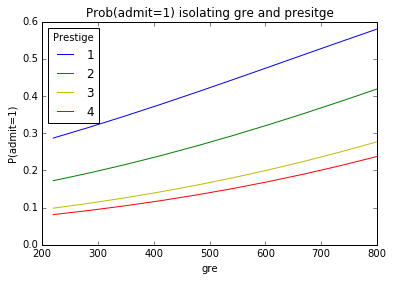

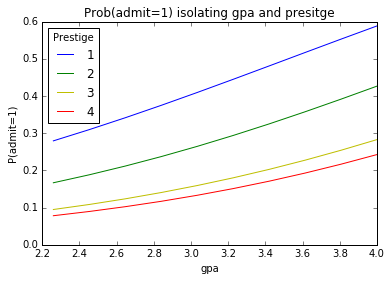

In [23]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                            aggfunc=np.mean)
    
    # in case you're curious as to what this looks like
    # print grouped.head()
    #                      admit_pred
    # gre        prestige            
    # 220.000000 1           0.282462
    #            2           0.169987
    #            3           0.096544
    #            4           0.079859
    # 284.444444 1           0.311718
    
    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'],
                color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and presitge")
    pl.show()


isolate_and_plot('gre')
isolate_and_plot('gpa')



##### inspired by the great blog post: http://blog.yhathq.com/posts/logistic-regression-and-python.html  